In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon
from sklearn import datasets, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y
from collections import Counter

In [2]:
#carrega a base wine
wine = datasets.load_wine()
wine_X = wine.data
wine_y = wine.target

In [3]:
#carrega a base breast cancer
cancer = datasets.load_breast_cancer()
cancer_X = cancer.data
cancer_y = cancer.target

In [4]:
#carrega a base digits
digits = datasets.load_digits()
digits_X = digits.data
digits_y = digits.target

In [5]:
#definido o classificador heterogeneouspooling
class HeterogenousPoolingClassifier(BaseEstimator):
    def __init__(self, n_samples=None):
        super().__init__()
        self.n_samples = n_samples #apenas um hiperparametro
    
    #método fit() para treinamento dos classificadores base    
    def fit(self,x_train,y_train):
        classificadores = [] #array classifiacdores: array para salvar os classificadores base depois de treinados
        x_train,y_train = check_X_y(x_train,y_train)
        
        #_ordem_classes: array com as classes da base de treino original, em ordem decrescente(utlizado para desempate)
        df_aux = pd.DataFrame(data=y_train)
        df_ordem = df_aux.value_counts(df_aux[0])
        dados_ordem = pd.DataFrame(data=df_ordem)
        self._ordem_classes  = dados_ordem.index.array
        
        #loop para criar novas bases de treino a partir da original, e ir fitando os classifiacdores base
        for i in range(self.n_samples):
            if i == 0:
                sub_X, sub_y = x_train, y_train
            else:
                sub_X, sub_y = resample(x_train, y_train, random_state=i-1)

            self.DT = DecisionTreeClassifier()
            self.DT.fit(sub_X,sub_y)
            classificadores.append(self.DT)
            
            self.gNB = GaussianNB()
            self.gNB.fit(sub_X,sub_y)
            classificadores.append(self.gNB)
            
            self.kNN = KNeighborsClassifier(n_neighbors=1)
            self.kNN.fit(sub_X,sub_y)
            classificadores.append(self.kNN)
        
        self._classificadores = classificadores

    #método predict(): usado para predizer a classe dos exemplos do conjunto de teste
    def predict(self,x_test):
        ordem_classes = self._ordem_classes
        
        #predicts: vai conter uma lista com todos os predicts para cada classificador base
        predicts = []
        for classificador in self._classificadores:
            predict = classificador.predict(x_test)
            predicts.append(predict)
      
        dados_todos = pd.DataFrame(data=predicts)
        
        #predicao: array que será retornado pelo método predict
        #contendo cada uma das predição(para o hgpooling) para cada exemplo do conjunto de teste
        predicao = []
        
        for index in dados_todos: #loop para percorrer cada exemplo do conjunto de teste
            coluna = dados_todos[index] #coluna: todos os predicts dos classificadores base para um exemplo do teste
            
            #mostc: vai ser nx2 => na primeira coluna[0] vai ter a classe, na segunda[1] a quantidade
            #em ordem decrescente
            mostc = Counter(coluna).most_common() 

            #a condição a seguir cria um array empatados[]
            #para salvar os primeiros colocados entre 
            empatados = []
            if len(mostc) == 1: #caso só exista uma classe, não tem como ter empate, logo retorna ela mesma
                empatados.append(mostc[0][0])
            else: #caso tenha mais que uma classe, verifica se tem quantidades iguais
                for ind in range(len(mostc)-1):
                    if len(mostc) == 1:
                        empatados.append(mostc[ind][0])
                        break
                    else:
                        if mostc[ind][1] == mostc[ind+1][1]:
                            if empatados == []:    
                                empatados.append(mostc[ind][0])
                                empatados.append(mostc[ind+1][0])
                            else:
                                empatados.append(mostc[ind+1][0])
                        else:
                            if not empatados:
                                empatados.append(mostc[0][0])
                                break
                            else:
                                break
            #decisao: variavel auxiliar para armazenar o predict do atual exemplo
            #caso tenha mais de um no array empatados: vai usar o array ordem_classes para desempatar
            if len(empatados) != 1:                    
                for classe_ord in ordem_classes: #ordem_classes = array com a ordem para desempate obtido na base de treino original
                    for classe_pred in empatados: #empatados= array de classes empatadas
                        #o desempate é feito escolhendo entre os empatados o primeiro que aparecer na lista de ordem obitidos
                        if classe_ord == classe_pred: 
                            decisao = classe_pred
                            break
                    else:
                        continue
                    break
            else: #com apenas um, 
                decisao = empatados[0]
                    
            predicao.append(decisao)
            
        #predict = np.asarray(predicao)
        return np.asarray(predicao)

In [6]:
stdscaler = preprocessing.StandardScaler() #normalizacao z-score
grade = {'estimator__n_estimators': [10, 25, 50, 100]} #grade para ciclo interno
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=36851234) #ciclo externo


In [7]:
bagging = BaggingClassifier() #inicia o classificador
pipe_bagging = Pipeline([('scaler', stdscaler), ('estimator', bagging)]) #pipeline com o classificador e a normalizacao
gs_bagging = GridSearchCV(estimator=pipe_bagging, param_grid = grade, 
                  scoring='accuracy', cv = 4) #gridsearch com o pipeline e a grade(ciclo interno, 4 folds)

In [8]:
adaboost = AdaBoostClassifier()
pipe_adaboost = Pipeline([('scaler', stdscaler), ('estimator', adaboost)])
gs_adaboost = GridSearchCV(estimator=pipe_adaboost, param_grid = grade, 
                  scoring='accuracy', cv = 4)

In [9]:
randomforest = RandomForestClassifier()
pipe_randomforest = Pipeline([('scaler', stdscaler), ('estimator', randomforest)])
gs_randomforest = GridSearchCV(estimator=pipe_randomforest, param_grid = grade, 
                  scoring='accuracy', cv = 4)

In [10]:
hgPooling = HeterogenousPoolingClassifier()
grade_hgPooling={'estimator__n_samples': [1,3,5,7]} #a grade para o ciclo intenro do hgpooling é diferente, passando n_samples

pipe_hgPooling = Pipeline([('scaler', stdscaler), ('estimator', hgPooling)])

gs_hgPooling = GridSearchCV(estimator=pipe_hgPooling, param_grid = grade_hgPooling, scoring='accuracy', cv = 4)

In [11]:
#scores na base wine de cada classificador
scores_wine_bagging = cross_val_score(gs_bagging, wine_X, wine_y, scoring='accuracy', cv = rkf)
scores_wine_adaboost = cross_val_score(gs_adaboost, wine_X, wine_y, scoring='accuracy', cv = rkf)
scores_wine_randomforest = cross_val_score(gs_randomforest, wine_X, wine_y, scoring='accuracy', cv = rkf)
scores_wine_hgPooling = cross_val_score(gs_hgPooling, wine_X, wine_y, scoring='accuracy', cv = rkf)

In [12]:
#scores na base breast cancer de cada classificador
scores_cancer_bagging = cross_val_score(gs_bagging, cancer_X, cancer_y, scoring='accuracy', cv = rkf)
scores_cancer_adaboost = cross_val_score(gs_adaboost, cancer_X, cancer_y, scoring='accuracy', cv = rkf)
scores_cancer_randomforest = cross_val_score(gs_randomforest, cancer_X, cancer_y, scoring='accuracy', cv = rkf)
scores_cancer_hgPooling = cross_val_score(gs_hgPooling, cancer_X, cancer_y, scoring='accuracy', cv = rkf)

In [13]:
#scores na base digits de cada classificador
scores_digits_bagging = cross_val_score(gs_bagging, digits_X, digits_y, scoring='accuracy', cv = rkf)
scores_digits_adaboost = cross_val_score(gs_adaboost, digits_X, digits_y, scoring='accuracy', cv = rkf)
scores_digits_randomforest = cross_val_score(gs_randomforest, digits_X, digits_y, scoring='accuracy', cv = rkf)
scores_digits_hgPooling = cross_val_score(gs_hgPooling, digits_X, digits_y, scoring='accuracy', cv = rkf)

In [14]:
#função para calcular a média das acuracias, desvio padrão, intervalo a 95% inferior e superior
def scor(scores):
    mean = scores.mean()
    std = scores.std()
    inf, sup = stats.norm.interval(0.95, loc=mean,
                               scale=std/np.sqrt(len(scores)))
    return mean,std,inf,sup

In [15]:
#impressão das tabelas de média das acuracias, desvio padrão, intervalo a 95% inferior e superior
#
#WINE
print("~~ Wine ~~")
data_wine = {'Método':['Acuracia Media', 'Desvio Padrao', 'Inferior', 'Superior'],
        'bagging':scor(scores_wine_bagging),
        'adaboost':scor(scores_wine_adaboost),
        'randomforest':scor(scores_wine_randomforest),
        'hgPooling':scor(scores_wine_hgPooling)}

df_wine = pd.DataFrame(data_wine)
print(df_wine.T)

#
#BREAST CANCER
print("\n\n~~ Breast Cancer ~~")
data_cancer = {'Método':['Acuracia Media', 'Desvio Padrao', 'Inferior', 'Superior'],
        'bagging':scor(scores_cancer_bagging),
        'adaboost':scor(scores_cancer_adaboost),
        'randomforest':scor(scores_cancer_randomforest),
        'hgPooling':scor(scores_cancer_hgPooling)}

df_cancer = pd.DataFrame(data_cancer)
print(df_cancer.T)

#
#DIGITS
print("\n\n~~ Digits ~~")
data_digits = {'Método':['Acuracia Media', 'Desvio Padrao', 'Inferior', 'Superior'],
        'bagging':scor(scores_digits_bagging),
        'adaboost':scor(scores_digits_adaboost),
        'randomforest':scor(scores_digits_randomforest),
        'hgPooling':scor(scores_digits_hgPooling)}

df_digits = pd.DataFrame(data_digits)
print(df_digits.T)


~~ Wine ~~
                           0              1         2         3
Método        Acuracia Media  Desvio Padrao  Inferior  Superior
bagging             0.966231       0.056837  0.945892   0.98657
adaboost            0.912309       0.071514  0.886719    0.9379
randomforest        0.979303       0.030765  0.968294  0.990312
hgPooling            0.97549       0.042899  0.960139  0.990841


~~ Breast Cancer ~~
                           0              1         2         3
Método        Acuracia Media  Desvio Padrao  Inferior  Superior
bagging             0.961915       0.024082  0.953298  0.970533
adaboost            0.967784       0.023573  0.959349  0.976219
randomforest         0.96368       0.023082  0.955421   0.97194
hgPooling           0.956046       0.021166  0.948472  0.963621


~~ Digits ~~
                           0              1         2         3
Método        Acuracia Media  Desvio Padrao  Inferior  Superior
bagging              0.95438       0.013922  0.949399  0

##BOXPLOTS
As próximas 3 cells vão plotas os boxplot usando pandas DataFrame e o boxplot do Seaborn


~~ Wine ~~
[0.88888889 0.88888889 0.94444444 1.         0.88888889 0.94444444
 0.83333333 1.         0.94117647 0.94117647 0.72222222 0.83333333
 0.88888889 0.94444444 1.         0.88888889 0.88888889 0.88888889
 0.94117647 1.         1.         1.         0.83333333 0.94444444
 0.94444444 0.83333333 0.77777778 0.94444444 0.82352941 1.        ]


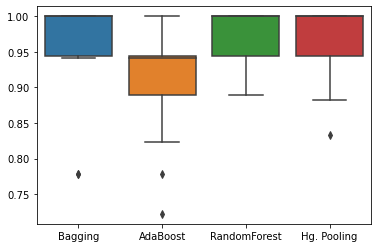

In [23]:
# WINE
data_wine_box = {'Bagging':scores_wine_bagging,
                'AdaBoost':scores_wine_adaboost,
                'RandomForest':scores_wine_randomforest,
                'Hg. Pooling':scores_wine_hgPooling}
df_wine_box = pd.DataFrame(data_wine_box) #,columns=["metodos","scores"]
print("\n~~ Wine ~~")
bplot_wine=sns.boxplot(data=df_wine_box)


~~ Breast Cancer ~~


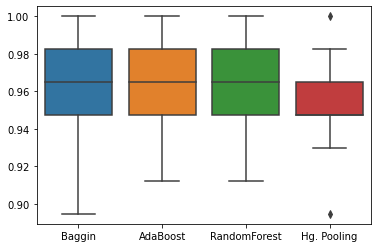

In [17]:
# BREAST CANCER
data_cancer_box = {'Baggin':scores_cancer_bagging,
                'AdaBoost':scores_cancer_adaboost,
                'RandomForest':scores_cancer_randomforest,
                'Hg. Pooling':scores_cancer_hgPooling}
df_cancer_box = pd.DataFrame(data_cancer_box)
print("\n~~ Breast Cancer ~~")
bplot_cancer=sns.boxplot(data=df_cancer_box)


~~ Digits ~~


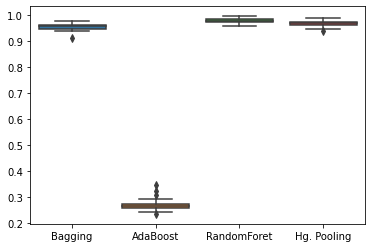

In [18]:
# DIGITS
data_digits_box = {'Bagging':scores_digits_bagging,
                'AdaBoost':scores_digits_adaboost,
                'RandomForet':scores_digits_randomforest,
                'Hg. Pooling':scores_digits_hgPooling}
df_digits_box = pd.DataFrame(data_digits_box)
print("\n~~ Digits ~~")
bplot_digits=sns.boxplot(data=df_digits_box)

In [19]:
# Paired t Test
s,p_rf_hp = ttest_rel(scores_wine_randomforest,scores_wine_hgPooling)
s,p_bagging_rf = ttest_rel(scores_wine_bagging, scores_wine_randomforest)
s,p_bagging_ada = ttest_rel(scores_wine_bagging, scores_wine_adaboost)
s,p_bagging_hp = ttest_rel(scores_wine_bagging, scores_wine_hgPooling)
s,p_ada_rf = ttest_rel(scores_wine_adaboost, scores_wine_randomforest)
s,p_ada_hp = ttest_rel(scores_wine_adaboost, scores_wine_hgPooling)

# Wilcoxon
s,pw_rf_hp = wilcoxon(scores_wine_randomforest,scores_wine_hgPooling)
s,pw_bagging_rf = wilcoxon(scores_wine_bagging, scores_wine_randomforest)
s,pw_bagging_ada = wilcoxon(scores_wine_bagging, scores_wine_adaboost)
s,pw_bagging_hp = wilcoxon(scores_wine_bagging, scores_wine_hgPooling)
s,pw_ada_rf = wilcoxon(scores_wine_adaboost, scores_wine_randomforest)
s,pw_ada_hp = wilcoxon(scores_wine_adaboost, scores_wine_hgPooling)
    
data_wine_p = [["Bagging",'{0:.5f}'.format(p_bagging_ada),'{0:.5f}'.format(p_bagging_rf),'{0:.5f}'.format(p_bagging_hp)], 
                    ['{0:.5f}'.format(pw_bagging_ada),"AdaBoost",'{0:.5f}'.format(p_ada_rf),'{0:.5f}'.format(p_ada_hp)],
                    ['{0:.5f}'.format(pw_bagging_rf),'{0:.5f}'.format(pw_ada_rf),"Random Forest",'{0:.5f}'.format(p_rf_hp)],
                    ['{0:.5f}'.format(pw_bagging_hp),'{0:.5f}'.format(pw_ada_hp),'{0:.5f}'.format(pw_rf_hp),"Heterogeneous Pooling"]]

df_wine_p = pd.DataFrame(data_wine_p)
print(df_wine_p.T)

         0         1              2                      3
0  Bagging   0.00263        0.11979                0.22167
1  0.00357  AdaBoost        0.00054                0.00088
2  0.10984   0.00017  Random Forest                0.56869
3  0.13841   0.00040        0.48586  Heterogeneous Pooling


C:\Users\jolua\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [20]:
# Paired t Test
s,p_rf_hp_cancer = ttest_rel(scores_cancer_randomforest,scores_cancer_hgPooling)
s,p_bagging_rf_cancer = ttest_rel(scores_cancer_bagging, scores_cancer_randomforest)
s,p_bagging_ada_cancer = ttest_rel(scores_cancer_bagging, scores_cancer_adaboost)
s,p_bagging_hp_cancer = ttest_rel(scores_cancer_bagging, scores_cancer_hgPooling)
s,p_ada_rf_cancer = ttest_rel(scores_cancer_adaboost, scores_cancer_randomforest)
s,p_ada_hp_cancer = ttest_rel(scores_cancer_adaboost, scores_cancer_hgPooling)

# Wilcoxon
s,pw_rf_hp_cancer = wilcoxon(scores_cancer_randomforest,scores_cancer_hgPooling)
s,pw_bagging_rf_cancer = wilcoxon(scores_cancer_bagging, scores_cancer_randomforest)
s,pw_bagging_ada_cancer = wilcoxon(scores_cancer_bagging, scores_cancer_adaboost)
s,pw_bagging_hp_cancer = wilcoxon(scores_cancer_bagging, scores_cancer_hgPooling)
s,pw_ada_rf_cancer = wilcoxon(scores_cancer_adaboost, scores_cancer_randomforest)
s,pw_ada_hp_cancer = wilcoxon(scores_cancer_adaboost, scores_cancer_hgPooling)
    
data_cancer_p = [["Bagging",'{0:.5f}'.format(p_bagging_ada_cancer),'{0:.5f}'.format(p_bagging_rf_cancer),'{0:.5f}'.format(p_bagging_hp_cancer)], 
                    ['{0:.5f}'.format(pw_bagging_ada_cancer),"AdaBoost",'{0:.5f}'.format(p_ada_rf_cancer),'{0:.5f}'.format(p_ada_hp_cancer)],
                    ['{0:.5f}'.format(pw_bagging_rf_cancer),'{0:.5f}'.format(pw_ada_rf_cancer),"Random Forest",'{0:.5f}'.format(p_rf_hp_cancer)],
                    ['{0:.5f}'.format(pw_bagging_hp_cancer),'{0:.5f}'.format(pw_ada_hp_cancer),'{0:.5f}'.format(pw_rf_hp_cancer),"Heterogeneous Pooling"]]

df_cancer_p = pd.DataFrame(data_cancer_p)
print(df_cancer_p.T)

         0         1              2                      3
0  Bagging   0.05243        0.52675                0.15902
1  0.05738  AdaBoost        0.29649                0.00397
2  0.57151   0.30355  Random Forest                0.01008
3  0.11561   0.00289        0.01664  Heterogeneous Pooling


In [21]:
# Paired t Test
s,p_rf_hp_digits = ttest_rel(scores_digits_randomforest,scores_digits_hgPooling)
s,p_bagging_rf_digits = ttest_rel(scores_digits_bagging, scores_digits_randomforest)
s,p_bagging_ada_digits = ttest_rel(scores_digits_bagging, scores_digits_adaboost)
s,p_bagging_hp_digits = ttest_rel(scores_digits_bagging, scores_digits_hgPooling)
s,p_ada_rf_digits = ttest_rel(scores_digits_adaboost, scores_digits_randomforest)
s,p_ada_hp_digits = ttest_rel(scores_digits_adaboost, scores_digits_hgPooling)

# Wilcoxon
s,pw_rf_hp_digits = wilcoxon(scores_digits_randomforest,scores_digits_hgPooling)
s,pw_bagging_rf_digits = wilcoxon(scores_digits_bagging, scores_digits_randomforest)
s,pw_bagging_ada_digits = wilcoxon(scores_digits_bagging, scores_digits_adaboost)
s,pw_bagging_hp_digits = wilcoxon(scores_digits_bagging, scores_digits_hgPooling)
s,pw_ada_rf_digits = wilcoxon(scores_digits_adaboost, scores_digits_randomforest)
s,pw_ada_hp_digits = wilcoxon(scores_digits_adaboost, scores_digits_hgPooling)
    
data_digits_p = [["Bagging",'{0:.5f}'.format(p_bagging_ada_digits),'{0:.5f}'.format(p_bagging_rf_digits),'{0:.5f}'.format(p_bagging_hp_digits)], 
                    ['{0:.5f}'.format(pw_bagging_ada_digits),"AdaBoost",'{0:.5f}'.format(p_ada_rf_digits),'{0:.5f}'.format(p_ada_hp_digits)],
                    ['{0:.5f}'.format(pw_bagging_rf_digits),'{0:.5f}'.format(pw_ada_rf_digits),"Random Forest",'{0:.5f}'.format(p_rf_hp_digits)],
                    ['{0:.5f}'.format(pw_bagging_hp_digits),'{0:.5f}'.format(pw_ada_hp_digits),'{0:.5f}'.format(pw_rf_hp_digits),"Heterogeneous Pooling"]]

df_digits_p = pd.DataFrame(data_digits_p)
print(df_digits_p.T)

         0         1              2                      3
0  Bagging   0.00000        0.00000                0.00040
1  0.00000  AdaBoost        0.00000                0.00000
2  0.00000   0.00000  Random Forest                0.00003
3  0.00027   0.00000        0.00001  Heterogeneous Pooling
